In [70]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt
import json

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [71]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [72]:
Des = pd.read_csv("Descriptive_name.csv", sep =";")

In [73]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037
5,Histidine,his__L,cpd00119,C00135
6,Leucine,leu__L,cpd00107,C00123
7,Lysine,lys__L,cpd00039,C00047
8,Ornithine,orn,cpd00064,C00077
9,Phenylalanine,phe__L,cpd00066,C00079


In [74]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

## 1) Constructing of a compartment community model
We will costruct a community model as following:
* We will name each non-exchange reaction and associated metabolites or compartments by: id + model_id, where model_id is the identifier of the model. Thus cobra will consider them as seperate systems.
* We will add the exchange metabolites and reactions unchanged as the envirionment as they should be shared by both models! We define the set of all exchange reactions as the union of the single set.

In [75]:
def modify_reaction_id(rec, id):
    # Mark reaktion by organism id, copy all attributes
    new_reaction = cobra.Reaction(rec.id + id)
    new_reaction.name = rec.name 
    new_reaction.subsystem = rec.subsystem
    new_reaction.lower_bound = rec.lower_bound
    new_reaction.upper_bound = rec.upper_bound
    # Create new metabolites for reaction
    metabolites = rec.metabolites
    new_mets = dict()
    for met, val in metabolites.items(): 
        # Reaction should be copied, but assign metabilites to organism by id
        comp = met.compartment 
        if comp != "e":
            # If it is not an exchanged metabolite, assign id
            new_met = cobra.Metabolite(met.id + id, formula=met.formula, name=met.name, compartment=comp + id)
        else:
            # If it is an exchange metabolite, then do not assign id
            new_met = cobra.Metabolite(met.id, formula=met.formula, name=met.name, compartment=comp)
        new_mets[new_met] = val # Same stoichimetry
    new_reaction.add_metabolites(new_mets)
    new_reaction.gene_reaction_rule = rec.gene_reaction_rule
    try:
        # This does not work for every reactions...
        new_reaction.genes = rec.genes
    except:
        pass
    return new_reaction

In [76]:
def create_community_model(models, biomass_functions, weights = "auto", medium="auto"):
    """ This methods builds a community model given a list of single models. 

    It does this by renaming all metabolites/reactions with species specific ids  """
    ids = [model.id for model in models]
    model_id = "community_" +"__".join([model.id for model in models])
    model = cobra.Model("Community model")
    for model_i in models:
        id = "_" + model_i.id
        reactions = model_i.reactions.copy()
        new_reactions = []
        for rec in reactions:
            if "EX_" in rec.id:
                # Add exchange reactions unchanged -> Shared by organisms!
                if not rec in model.exchanges:
                    model.add_reactions([rec])
            else:
                # Modify reactions that they are recognized as different.
                new_reaction = modify_reaction_id(rec,id)
                new_reactions.append(new_reaction)
        model.add_reactions(new_reactions)
    # Compute weights: Such that all models have same growth on their medium!
    if weights == "auto":
        biomass = []
        for model_i in models:
            biomass.append(model_i.slim_optimize())
        max_biomass = np.max(biomass)
        weights = [max_biomass/g for g in biomass]
    
    # Set objective as sum of growth
    objective = []
    for i, growth in enumerate(biomass_functions):
        v_i = weights[i] * model.reactions.get_by_id(growth + "_" + ids[i]).flux_expression
        objective.append(v_i)
    model.objective = sum(objective)
    if medium=="auto":
        # Set medium to union of model mediums
        medium = dict()
        for m in models:
            for key ,val in m.medium.items():
                medium[key] = val
        model.medium = medium 
    else:
        model.medium = medium

    return model

## Investigate COMPM

The medium should induce competition!

In [77]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())

In [78]:
compm = dict()
for key, val in compm_SA.items():
    compm[key] = val 
for key, val in compm_DP.items():
    compm[key] = val 

In [79]:
model = create_community_model(models, [BIOMASS_DP, BIOMASS_SA], weights=[1.,1.], medium=compm)

There are no boundary reactions in this model. Therefore specific types of boundary reactions such as 'exchanges', 'demands' or 'sinks' cannot be identified.


In [80]:
model.medium = compm

In [81]:
opt = model.optimize()
print("SA growth: " + str(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux))
print("DP growth: " + str(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux))

SA growth: 2.5586946126136905
DP growth: -1.0224043833773067e-12


In [82]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,3.96,6,19.91%
cl_e,EX_cl_e,0.01267,0,0.00%
cys__L_e,EX_cys__L_e,0.4193,3,1.05%
fe2_e,EX_fe2_e,0.03776,0,0.00%
glc__D_e,EX_glc__D_e,7.913,6,39.79%
glu__L_e,EX_glu__L_e,3.548,5,14.87%
his__L_e,EX_his__L_e,0.1542,6,0.78%
ile__L_e,EX_ile__L_e,0.07944,6,0.40%
k_e,EX_k_e,0.4751,0,0.00%
leu__L_e,EX_leu__L_e,0.8035,6,4.04%


In [83]:
x1 =[]
y1 =[]
z1 =[]
for met, f in model.medium.items():
    with model:
        medium = model.medium 
        medium[met] = 0
        model.medium = medium
        model.optimize()
        print(met)
        print("SA growth: " + str(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux))
        print("DP growth: " + str(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux))
        for j in range(len(Des)):
            ide = "EX_" + str(Des.iloc[j][1]) + "_e"
            if met == ide:
                x1.append(str(Des.iloc[j][0]))
                y1.append(round(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux,3))
                z1.append(round(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux,3))  

EX_glc__D_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_h2o_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_leu__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_4abz_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_ala__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_cl_e
SA growth: 0.0
DP growth: 0.0
EX_pi_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_ribflv_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_gly_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_thr__L_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_arg__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_lys__L_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_orn_e
SA growth: 2.558694612613441
DP growth: -9.729994587814872e-13
EX_k_e
SA growth: 0.0
DP growth: 0.0
EX_pro__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_ca2_e
SA growth: 2.558694612613441
DP growth: -9.72999458

In [84]:
model = create_community_model(models, [BIOMASS_DP, BIOMASS_SA], weights=[10.,1.], medium=compm)

There are no boundary reactions in this model. Therefore specific types of boundary reactions such as 'exchanges', 'demands' or 'sinks' cannot be identified.


In [85]:
opt = model.optimize()
print("SA growth: " + str(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux))
print("DP growth: " + str(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux))

SA growth: 2.1755067515083337
DP growth: 0.07290151281852741


In [86]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
26dap__M_e,EX_26dap__M_e,0.00706,7,0.04%
4abz_e,EX_4abz_e,4.723E-05,7,0.00%
ala__L_e,EX_ala__L_e,0.1381,3,0.35%
arg__L_e,EX_arg__L_e,3.056,6,15.68%
ca2_e,EX_ca2_e,0.00379,0,0.00%
cl_e,EX_cl_e,0.01506,0,0.00%
cobalt2_e,EX_cobalt2_e,0.002577,0,0.00%
cu2_e,EX_cu2_e,0.00239,0,0.00%
cys__L_e,EX_cys__L_e,0.3679,3,0.94%
fe2_e,EX_fe2_e,0.03755,0,0.00%


In [87]:
x2 =[]
y2 =[]
z2 =[]
for met, f in model.medium.items():
    with model:
        medium = model.medium 
        medium[met] = 0
        model.medium = medium
        model.optimize()
        print(met)
        print("SA growth: " + str(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux))
        print("DP growth: " + str(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux))
        for j in range(len(Des)):
            ide = "EX_" + str(Des.iloc[j][1]) + "_e"
            if met == ide:
                x2.append(str(Des.iloc[j][0]))
                y2.append(round(model.reactions.get_by_id(BIOMASS_SA + "_" + model_SA.id).flux,3))
                z2.append(round(model.reactions.get_by_id(BIOMASS_DP + "_" + model_DP.id).flux,3))  

EX_glc__D_e
SA growth: 2.4495257486583815
DP growth: 0.02076938270447598
EX_h2o_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852744
EX_leu__L_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852744
EX_4abz_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_ala__L_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_cl_e
SA growth: 0.0
DP growth: 0.0
EX_pi_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_ribflv_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_gly_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_thr__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_arg__L_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_lys__L_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_orn_e
SA growth: 2.1755067515083337
DP growth: 0.07290151281852741
EX_k_e
SA growth: 0.0
DP growth: 0.0
EX_pro__L_e
SA growth: 2.558694612613397
DP growth: 0.0
EX_ca2_e
SA growth: 2.5586946126085213
DP 

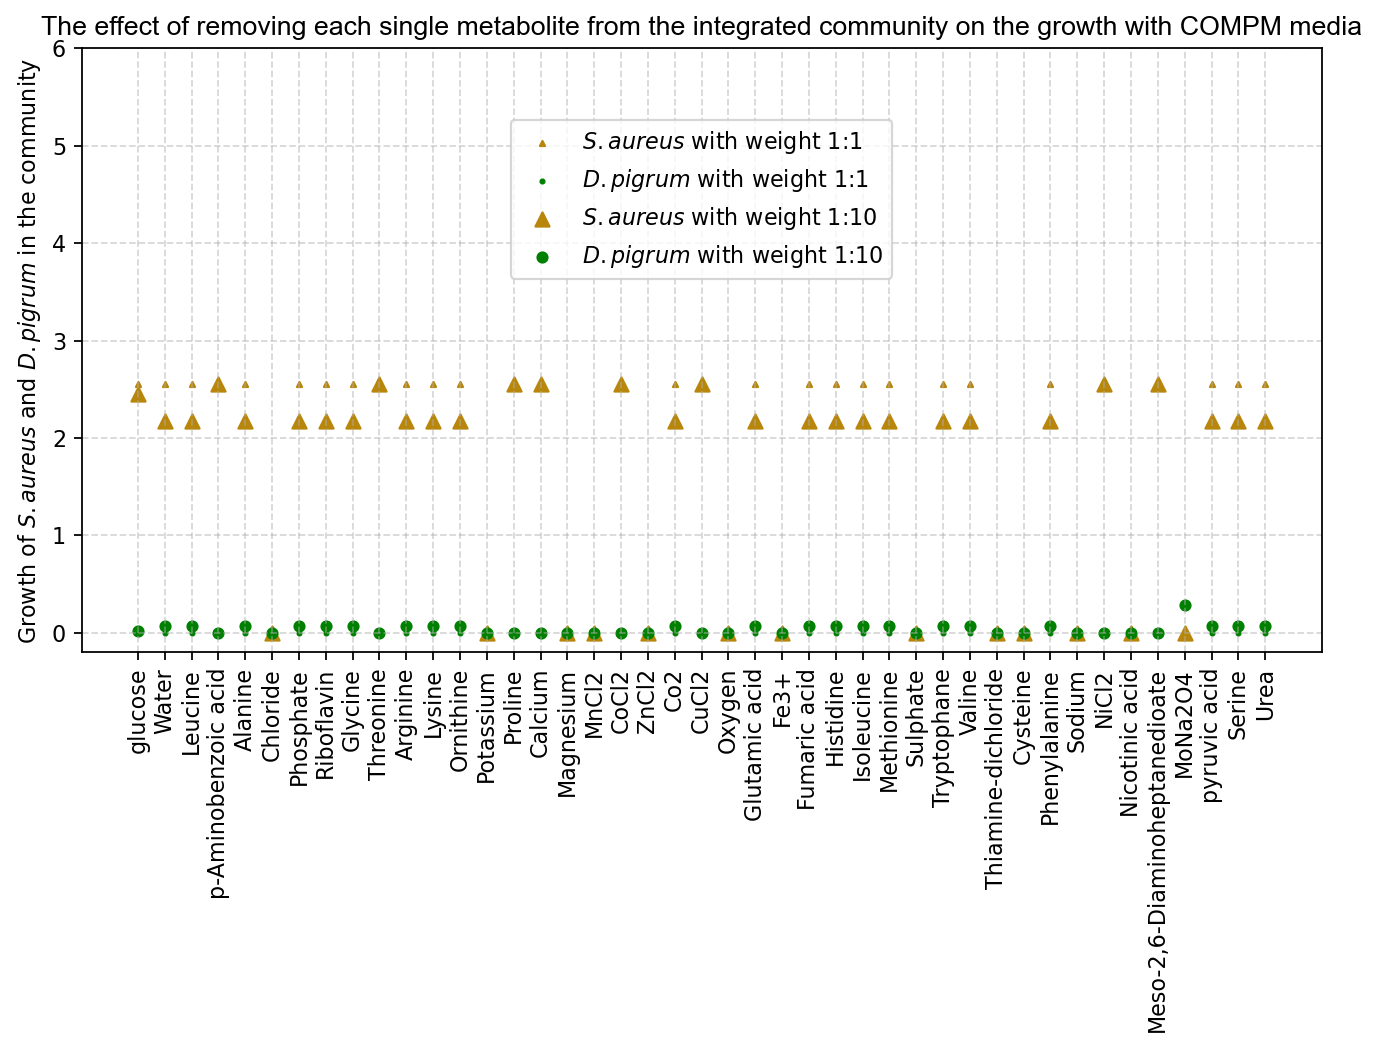

In [88]:
# Draw plot
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 
fig = plt.figure(figsize=(10,5), dpi= 160)

plt.scatter(x = x1, y = y1, color="darkgoldenrod",s=5, marker="^")
plt.scatter(x = x1, y = z1, color="green",s=3, marker="o")
plt.scatter(x = x2, y = y2, color="darkgoldenrod",s=40, marker="^")
plt.scatter(x = x2, y = z2, color="green",s=20, marker="o")
plt.ylim(-0.2,6)     
plt.legend(["$\it{S.aureus}$ with weight 1:1" , "$\it{D. pigrum}$ with weight 1:1", "$\it{S.aureus}$ with weight 1:10" , "$\it{D. pigrum}$ with weight 1:10"], loc=8, bbox_to_anchor=(0.5, 0.6))

# Decorations    
plt.title('The effect of removing each single metabolite from the integrated community on the growth with COMPM media', **title_font)

plt.xticks(x1,rotation=90)
plt.grid(linestyle='--', alpha=0.5)
plt.ylabel("Growth of $\it{S.aureus}$ and $\it{D. pigrum}$ in the community")
#fig.tight_layout()

plt.savefig("Integrated_community_remove_metabolite_growth_effect_media_compm.pdf", bbox_inches='tight', dpi=1000) 
plt.show()

In [89]:
len(x1)

43

In [90]:
len(x2)

43

In [91]:
compm

{'EX_cl_e': 0.016592706807384002,
 'EX_pyr_e': 10.0,
 'EX_so4_e': 0.010557173971642877,
 'EX_mg2_e': 0.024203301149647583,
 'EX_co2_e': 0.21226941455991016,
 'EX_ser__L_e': 10.0,
 'EX_glc__D_e': 10.0,
 'EX_arg__L_e': 10.0,
 'EX_thm_e': 0.001141177797225575,
 'EX_na1_e': 5.090522931794354,
 'EX_phe__L_e': 10.0,
 'EX_mn2_e': 0.010707719788924139,
 'EX_mobd_e': 1.7910862288293614e-05,
 'EX_trp__L_e': 0.03925018692530509,
 'EX_o2_e': 20.0,
 'EX_cys__L_e': 10.0,
 'EX_lys__L_e': 0.9223436956285822,
 'EX_leu__L_e': 0.8034579715954936,
 'EX_nac_e': 7.953051307191044,
 'EX_orn_e': 10.0,
 'EX_pi_e': 5.519506278294781,
 'EX_k_e': 0.47512400261618165,
 'EX_his__L_e': 0.15415385138287618,
 'EX_ribflv_e': 0.0007637848411345721,
 'EX_urea_e': 10.0,
 'EX_zn2_e': 0.008993582449543406,
 'EX_fe2_e': 0.037761215092876554,
 'EX_glu__L_e': 10.0,
 'EX_val__L_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_thr__L_e': 0.06937020546125328,
 'EX_fum_e': 10.0,
 'EX_26dap__M_e': 0.02734480105817464,
 'EX_ni2_e': 0.0100226130100